In [1]:
import pandas as pd 
import numpy as np 
import os
from google.cloud import bigquery
from google.oauth2 import service_account
from datetime import datetime
from dateutil.relativedelta import relativedelta
import itertools
from functions import *
from constants import *
from datetime import datetime
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

# declaramos las credenciales al entorno de desarollo
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "..\\..\\bd\\0_docs\\datahub-deacero-adojeda.json"

# Crear date_today como el primer día del mes actual
now = datetime.now() - relativedelta(days= 4)

date_today = datetime(now.year, now.month, 1)

# Crear date_last_6m como seis meses antes de date_today
date_last_6m = date_today - relativedelta(months=6)

# Crear date_forecas como seis meses después de date_today
date_forecas = date_today + relativedelta(months=7)

# Mostrar las fechas
print("date_today:", date_today.strftime("%Y-%m-%d"))

print("date_last_6m:", date_last_6m.strftime("%Y-%m-%d"))

print("date_forecas:", date_forecas.strftime("%Y-%m-%d"))

c:\Users\adojeda\OneDrive - deacero.com\dev\0_envs\.bigquery\Lib\site-packages\google\cloud\bigquery\table.py:1900: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


RESULTADOS PRIMEER CONSULTA:


,FECHA_EJECUCION,TEST,MODEL,FORECAST_TO_DO,MONTHS_TO_FORECAST,MONTHS_TO_TEST,FROM_YEAR,TOTAL_MODELOS,MAPE_DEACERO,P15,P50,P85,MIN_MAPE_DEACERO,MAX_MAPE_DEACERO,NUMERO_COMBINACIONES
0,2025-09-23 07:44:21,1,SVR,ToneladasFacturadas,6,6,2022,1,136.855234,17.408,43.328,117.4321,2.589,8862.5278,635


PARAMETROS DE EJECUCION:
2022 6 6
date_today: 2025-09-01
date_last_6m: 2025-03-01
date_forecas: 2026-04-01


## Generamos Resultados Modelo MIDAS V1

In [2]:
ls "../../bd/Facturacion BQ/MIDAS"

 El volumen de la unidad C es Windows 
 El n�mero de serie del volumen es: FC47-8A0A

 Directorio de c:\Users\adojeda\OneDrive - deacero.com\bd\Facturacion BQ\MIDAS

24/09/2025  08:48 a. m.    <DIR>          .
09/09/2025  09:16 a. m.    <DIR>          ..
11/09/2025  09:07 a. m.    <DIR>          20250717
11/09/2025  09:10 a. m.    <DIR>          20250909
17/09/2025  11:12 a. m.    <DIR>          20250917
18/09/2025  06:14 p. m.    <DIR>          20250918
22/09/2025  09:03 a. m.    <DIR>          20250919_5M
24/09/2025  08:50 a. m.    <DIR>          20250924_test
10/09/2025  08:06 a. m.    <DIR>          PRONOSTICO 2025
               0 archivos              0 bytes
               9 dirs  318,926,614,528 bytes libres


In [3]:
LIST_DIR ="../../bd/Facturacion BQ/MIDAS/20250924_test" #20250919_5M" <.-cambié de carpeta???? no sé si cambio el proceso.... validar

list_df = []
for num, path in  enumerate(os.listdir(LIST_DIR)):
    print(num, path)
    df =pd.read_excel(LIST_DIR + "/" + path)
    list_df.append(df)
    del df
base = pd.concat(list_df)
del list_df

base_t = transform_MIDAS(base)

base_t['WOC_v1'] = base_t[['BayesianRidge', 'GradientBoostingRegressor', 'KNeighborsRegressor','LGBMRegressor', 'RandomForestRegressor', 'Ridge', 'SVR','XGBRegressor']].fillna(0).mean(axis = 1)
base_t.sample(5)

0 outputs_BayesianRidge_FORECAST_NombreSubdireccion_ToneladasFacturadas_20250923_225952.csv
1 outputs_GradientBoostingRegressor_FORECAST_NombreSubdireccion_ToneladasFacturadas_20250923_233850.csv
2 outputs_KNeighborsRegressor_FORECAST_NombreSubdireccion_ToneladasFacturadas_20250923_232757.csv
3 outputs_LGBMRegressor_FORECAST_NombreSubdireccion_ToneladasFacturadas_20250923_230916.csv
4 outputs_RandomForestRegressor_FORECAST_NombreSubdireccion_ToneladasFacturadas_20250923_222413.csv
5 outputs_Ridge_FORECAST_NombreSubdireccion_ToneladasFacturadas_20250923_231838.csv
6 outputs_SVR_FORECAST_NombreSubdireccion_ToneladasFacturadas_20250923_225036.csv
7 outputs_XGBRegressor_FORECAST_NombreSubdireccion_ToneladasFacturadas_20250923_224116.csv


,MesAnio,NombreSubdireccion,NombreGrupoEstadistico3,BayesianRidge,GradientBoostingRegressor,KNeighborsRegressor,LGBMRegressor,RandomForestRegressor,Ridge,SVR,XGBRegressor,Y_HIST2,WOC_v1
9658,2026-03-01,INDUSTRIAL WIRE,A.GALV. C4,287.790063,278.192079,278.192079,221.293815,280.969808,278.862945,255.646589,264.416351,NaN,268.170466
5809,2025-08-01,ALMACEN ANSA,CLAVO ALFILERILLO,0.166900,0.260600,0.452300,0.342800,0.367400,0.076100,0.313000,0.311300,0.200,0.286300
7715,2025-11-01,MAYORISTAS ACEROS,VARILLA 6000,84.372700,87.419400,87.420300,97.410000,88.495300,84.355600,74.394600,87.389702,NaN,86.407200
2516,2025-01-01,NORTE,GRAPA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.575,0.000000
1702,2024-12-01,CENTRO SUR,REJA FORTE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.207,0.000000


In [4]:
base_t.groupby("MesAnio").sum(numeric_only = True).round(0)

,BayesianRidge,GradientBoostingRegressor,KNeighborsRegressor,LGBMRegressor,RandomForestRegressor,Ridge,SVR,XGBRegressor,Y_HIST2,WOC_v1
MesAnio,,,,,,,,,,
2024-09-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,189571.0,0.0
2024-10-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,200035.0,0.0
2024-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203149.0,0.0
2024-12-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,173369.0,0.0
2025-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,225665.0,0.0
2025-02-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206128.0,0.0
2025-03-01,228393.0,207677.0,208212.0,201048.0,207857.0,207336.0,205185.0,214466.0,212186.0,210022.0
2025-04-01,234447.0,203689.0,203331.0,197931.0,204153.0,200857.0,205846.0,205979.0,203224.0,207029.0
2025-05-01,211031.0,200538.0,200834.0,202742.0,200402.0,200187.0,207161.0,206925.0,203738.0,203728.0


## GENERAMOS HISTORICOS DE PV, PVO Y FACTURACION DESDE BQ

In [5]:
FACT = load_fact_pvo_pv()
FACT = add_zeros(FACT, date_today)
FACT.sample(5)

Consultando PV
Consultando PVO
Consultando FACT
2779
2779
2779
(79930, 11)
0 NombreGrupo
1 NombreDireccion
2 NombreSubdireccion
3 NombreGrupoEstadistico1
4 NombreGrupoEstadistico2
5 NombreGrupoEstadistico3
2090


,MesAnio,id,NombreGrupo,NombreDireccion,NombreSubdireccion,NombreGrupoEstadistico1,NombreGrupoEstadistico2,NombreGrupoEstadistico3,toneladas_pvo,toneladas_plan_ventas,toneladas_facturadas,valid_ton,TP_MESES,TP_MOVIL,id2
12637,2025-02-01,ACEROS_EXPORTACION ACEROS_EXPORTACIÓN ACEROS_P...,ACEROS,EXPORTACION ACEROS,EXPORTACIÓN ACEROS,PERFILES,PERFILES COMERCIALES,ANGULOS COMERCIALES,0.0000,0.0,0.000,0.0000,0.000,0.0,EXPORTACIÓN ACEROS_ANGULOS COMERCIALES
37290,2025-05-01,ALAMBRES_ALAMBRES_SOLUCIONES_MALLAS Y ALAMBRES...,ALAMBRES,ALAMBRES,SOLUCIONES,MALLAS Y ALAMBRES,INDUSTRIAL GALV.,RETENIDAS DELGADA,NaN,NaN,0.000,0.0000,0.000,0.0,SOLUCIONES_RETENIDAS DELGADA
64390,2025-05-01,FILIALES ALAMBRES_INDASA_INDASA_MALLAS Y ALAMB...,FILIALES ALAMBRES,INDASA,INDASA,MALLAS Y ALAMBRES,CERCOS ESPECIALIZADOS,CERCOS GRADUADAS,NaN,NaN,0.104,0.1040,0.000,0.062667,INDASA_CERCOS GRADUADAS
2446,2025-11-01,ACEROS_ACEROS MEXICO_MAYORISTAS ACEROS_MALLAS ...,ACEROS,ACEROS MEXICO,MAYORISTAS ACEROS,MALLAS Y ALAMBRES,CERCOS ESPECIALIZADOS,REJA CLASICA,0.1338,0.0,0.000,0.1338,2.966,0.031759,MAYORISTAS ACEROS_REJA CLASICA
59646,2025-11-01,DEACERO SOLUTIONS_INGETEK_PERFILES MEXICO_PERF...,DEACERO SOLUTIONS,INGETEK,PERFILES MEXICO,PERFILES,PERFILES ESTRUCTURALES,CANALES ESTRUCTURALES,NaN,NaN,NaN,0.0000,NaN,0.0,PERFILES MEXICO_CANALES ESTRUCTURALES


In [6]:
FACT.groupby("MesAnio")[["toneladas_pvo","toneladas_plan_ventas","toneladas_facturadas"]].sum().round(0)

,toneladas_pvo,toneladas_plan_ventas,toneladas_facturadas
MesAnio,,,
2025-01-01,319541.0,309265.0,328487.0
2025-02-01,323747.0,330500.0,301610.0
2025-03-01,314116.0,311392.0,298606.0
2025-04-01,297967.0,299818.0,276743.0
2025-05-01,349645.0,351032.0,286634.0
2025-06-01,354625.0,349853.0,269711.0
2025-07-01,320277.0,318095.0,285686.0
2025-08-01,317260.0,311227.0,316013.0
2025-09-01,347612.0,362910.0,198969.0


# POP 
Proceso de Optimización de Pronósticos?

El siguiente notebook permite Optimizar los pronósticos de Subdir-GE3 para seleccionar el modelo más adecuado.

El modelo adecuado será aquel que minimicé el MAPE Deacero a nivel SKU BU - ej. **$min(MAPE_{Deacero})$**  Seleccionado entre los siguientes Modelos

* PVO
* BayesianRidge	
* GradientBoostingRegressor	
* KNeighborsRegressor	
* LGBMRegressor	
* RandomForestRegressor
* Ridge	
* SVR
* XGBRegressor
* Demmand Management 

### Consulta RESULTADOS MODELO MIDAS_V2

In [7]:
forecast = data_bq(QUERY_RESULTADOS_MODEL2)
print("CONSULTANDO RESULTADOS MODELO 2")
forecast.sort_index(inplace=True, ascending=True)

forecast["Y_HIST"] = forecast["Y_HIST"].astype(float)
forecast["Y_PREDICCION"] = forecast["Y_PREDICCION"].astype(float)
forecast["Y_PRONOSTICOS"] = forecast["Y_PRONOSTICOS"].astype(float)
forecast["Y_TEST"] = forecast["Y_TEST"].astype(float)

#print(forecast.FECHA.value_counts().sort_index().tail(10))

out = transform_MIDAS(forecast)
print("TRANSFORMANDO DATOS")

out.MesAnio = pd.to_datetime(out.MesAnio)

display(out.groupby("MesAnio").sum(numeric_only = True).round(0))

out = out.merge(base_t, how = "left", on = ["MesAnio","NombreSubdireccion","NombreGrupoEstadistico3"] ,validate = "1:1", suffixes=('', '_v1'))

out["MAX_MODEL"] = True
# FACT LIMITA LOS RESULTADOS......
out = FACT.merge(out, how = "left", on = ["MesAnio","NombreSubdireccion","NombreGrupoEstadistico3"] ,validate = "1:1")

out["MAX_MODEL"] = out["MAX_MODEL"].fillna(False)

out.sample(5)

CONSULTANDO RESULTADOS MODELO 2
TRANSFORMANDO DATOS


,BayesianRidge,GradientBoostingRegressor,KNeighborsRegressor,LGBMRegressor,RandomForestRegressor,Ridge,SVR,XGBRegressor,Y_HIST2
MesAnio,,,,,,,,,
2024-09-01,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,190736.0
2024-10-01,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,200258.0
2024-11-01,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203769.0
2024-12-01,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,173655.0
2025-01-01,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,226006.0
2025-02-01,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206657.0
2025-03-01,6.593198e+16,208678.0,209455.0,202156.0,208158.0,208352.0,204008.0,208288.0,212932.0
2025-04-01,1.463079e+23,203579.0,203942.0,210852.0,203620.0,201865.0,208882.0,206652.0,204263.0
2025-05-01,5.451946e+25,200820.0,200932.0,204349.0,200363.0,201444.0,205278.0,208092.0,205227.0


,MesAnio,id,NombreGrupo,NombreDireccion,NombreSubdireccion,NombreGrupoEstadistico1,NombreGrupoEstadistico2,NombreGrupoEstadistico3,toneladas_pvo,toneladas_plan_ventas,toneladas_facturadas,valid_ton,TP_MESES,TP_MOVIL,id2,BayesianRidge,GradientBoostingRegressor,KNeighborsRegressor,LGBMRegressor,RandomForestRegressor,Ridge,SVR,XGBRegressor,Y_HIST2,BayesianRidge_v1,GradientBoostingRegressor_v1,KNeighborsRegressor_v1,LGBMRegressor_v1,RandomForestRegressor_v1,Ridge_v1,SVR_v1,XGBRegressor_v1,Y_HIST2_v1,WOC_v1,MAX_MODEL
2138,2025-11-01,ACEROS_ACEROS MEXICO_PERFILES NACIONAL_MALLAS ...,ACEROS,ACEROS MEXICO,PERFILES NACIONAL,MALLAS Y ALAMBRES,CERCOS,CONCERTINA,4.23752,4.23752,0.000,8.47504,1.693333,2.861056,PERFILES NACIONAL_CONCERTINA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
17783,2025-04-01,FILIALES ALAMBRES_DEACERO SUMMIT_DSS USA_INDUS...,FILIALES ALAMBRES,DEACERO SUMMIT,DSS USA,INDUSTRIAL FILIALES,CHQ,ALAMBRE CHQ C/TRAT,200.00000,200.00000,56.984,456.98400,411.380122,216.652482,DSS USA_ALAMBRE CHQ C/TRAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2519,2026-02-01,ACEROS_ACEROS MEXICO_PERFILES NACIONAL_MALLAS ...,ACEROS,ACEROS MEXICO,PERFILES NACIONAL,MALLAS Y ALAMBRES,INDUSTRIAL GALV.,A. GALV AC C3,NaN,NaN,NaN,0.00000,NaN,0.0,PERFILES NACIONAL_A. GALV AC C3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
19882,2025-03-01,FILIALES ALAMBRES_TURIA_TURIA_VARILLA_VARILLA ...,FILIALES ALAMBRES,TURIA,TURIA,VARILLA,VARILLA ROLLO,COIL REBAR,NaN,0.00000,0.000,0.00000,0.000000,16.236667,TURIA_COIL REBAR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
13636,2025-01-01,ALAMBRES_EXPORTACIÓN ALAMBRES_EXPORTACIÓN ALAM...,ALAMBRES,EXPORTACIÓN ALAMBRES,EXPORTACIÓN ALAMBRES,MALLAS Y ALAMBRES,INDUSTRIAL NEGROS,REC IND,0.00000,0.00000,0.000,0.00000,0.000000,7.259167,EXPORTACIÓN ALAMBRES_REC IND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


### PROCESO POP

In [14]:
df = out.copy()

#FILTRO LIMITE INFERIOR
df = df [df.MesAnio >= date_last_6m]

#FILTRO LIMITE SUPERIOR?

df = df [df.MesAnio <= date_forecas]

df['Segmento'] = np.where ((df.MesAnio >= date_last_6m) & (df.MesAnio < date_today), "Validacion", "Pronostico")

# Agregando modelo WOC
#df['WOC'] = df.mean(numeric_only = True, axis = 1)
df['WOC'] = df[['BayesianRidge', 'GradientBoostingRegressor', 'KNeighborsRegressor','LGBMRegressor', 'RandomForestRegressor', 'Ridge', 'SVR','XGBRegressor']].fillna(0).mean(axis = 1)

df['WOC_v1'] = df[['BayesianRidge_v1', 'GradientBoostingRegressor_v1', 'KNeighborsRegressor_v1','LGBMRegressor_v1', 'RandomForestRegressor_v1', 'Ridge_v1', 'SVR_v1','XGBRegressor_v1']].fillna(0).mean(axis = 1)

df.groupby("MesAnio").Segmento.last()

MesAnio
2025-03-01    Validacion
2025-04-01    Validacion
2025-05-01    Validacion
2025-06-01    Validacion
2025-07-01    Validacion
2025-08-01    Validacion
2025-09-01    Pronostico
2025-10-01    Pronostico
2025-11-01    Pronostico
2025-12-01    Pronostico
2026-01-01    Pronostico
2026-02-01    Pronostico
Name: Segmento, dtype: object

In [15]:
display(df.isna().sum())

# imputamos 0s
df.fillna(0, inplace=True)

display(df.isna().sum())

df.tail()

MesAnio                             0
id                                  0
NombreGrupo                         0
NombreDireccion                     0
NombreSubdireccion                  0
NombreGrupoEstadistico1             0
NombreGrupoEstadistico2             0
NombreGrupoEstadistico3             0
toneladas_pvo                   12882
toneladas_plan_ventas           12375
toneladas_facturadas             5572
valid_ton                           0
TP_MESES                         2916
TP_MOVIL                         3163
id2                                 0
BayesianRidge                   18912
GradientBoostingRegressor       18912
KNeighborsRegressor             18912
LGBMRegressor                   18912
RandomForestRegressor           18912
Ridge                           18912
SVR                             18912
XGBRegressor                    18912
Y_HIST2                         21996
BayesianRidge_v1                18948
GradientBoostingRegressor_v1    18948
KNeighborsRe

MesAnio                         0
id                              0
NombreGrupo                     0
NombreDireccion                 0
NombreSubdireccion              0
NombreGrupoEstadistico1         0
NombreGrupoEstadistico2         0
NombreGrupoEstadistico3         0
toneladas_pvo                   0
toneladas_plan_ventas           0
toneladas_facturadas            0
valid_ton                       0
TP_MESES                        0
TP_MOVIL                        0
id2                             0
BayesianRidge                   0
GradientBoostingRegressor       0
KNeighborsRegressor             0
LGBMRegressor                   0
RandomForestRegressor           0
Ridge                           0
SVR                             0
XGBRegressor                    0
Y_HIST2                         0
BayesianRidge_v1                0
GradientBoostingRegressor_v1    0
KNeighborsRegressor_v1          0
LGBMRegressor_v1                0
RandomForestRegressor_v1        0
Ridge_v1      

,MesAnio,id,NombreGrupo,NombreDireccion,NombreSubdireccion,NombreGrupoEstadistico1,NombreGrupoEstadistico2,NombreGrupoEstadistico3,toneladas_pvo,toneladas_plan_ventas,toneladas_facturadas,valid_ton,TP_MESES,TP_MOVIL,id2,BayesianRidge,GradientBoostingRegressor,KNeighborsRegressor,LGBMRegressor,RandomForestRegressor,Ridge,SVR,XGBRegressor,Y_HIST2,BayesianRidge_v1,GradientBoostingRegressor_v1,KNeighborsRegressor_v1,LGBMRegressor_v1,RandomForestRegressor_v1,Ridge_v1,SVR_v1,XGBRegressor_v1,Y_HIST2_v1,WOC_v1,MAX_MODEL,Segmento,WOC
29255,2025-10-01,USA_EUA - CANADA_KEY STEEL ACCOUNTS_VARILLA_VA...,USA,EUA - CANADA,KEY STEEL ACCOUNTS,VARILLA,VARILLA,VARILLA RESTO,0.00000,0.0,0.0,0.00000,140.527333,3.912314,KEY STEEL ACCOUNTS_VARILLA RESTO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,Pronostico,0.0
29256,2025-11-01,USA_EUA - CANADA_KEY STEEL ACCOUNTS_VARILLA_VA...,USA,EUA - CANADA,KEY STEEL ACCOUNTS,VARILLA,VARILLA,VARILLA RESTO,0.00000,0.0,0.0,0.00000,6.804000,4.564366,KEY STEEL ACCOUNTS_VARILLA RESTO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,Pronostico,0.0
29257,2025-12-01,USA_EUA - CANADA_KEY STEEL ACCOUNTS_VARILLA_VA...,USA,EUA - CANADA,KEY STEEL ACCOUNTS,VARILLA,VARILLA,VARILLA RESTO,0.00000,0.0,0.0,0.00000,0.000000,3.964261,KEY STEEL ACCOUNTS_VARILLA RESTO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,Pronostico,0.0
29258,2026-01-01,USA_EUA - CANADA_KEY STEEL ACCOUNTS_VARILLA_VA...,USA,EUA - CANADA,KEY STEEL ACCOUNTS,VARILLA,VARILLA,VARILLA RESTO,0.00000,0.0,0.0,0.00000,27.168373,2.923987,KEY STEEL ACCOUNTS_VARILLA RESTO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,Pronostico,0.0
29259,2026-02-01,USA_EUA - CANADA_KEY STEEL ACCOUNTS_VARILLA_VA...,USA,EUA - CANADA,KEY STEEL ACCOUNTS,VARILLA,VARILLA,VARILLA RESTO,19.75174,0.0,0.0,19.75174,0.000000,3.411319,KEY STEEL ACCOUNTS_VARILLA RESTO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,Pronostico,0.0


In [16]:
df.columns [df.dtypes == float]

Index(['toneladas_pvo', 'toneladas_plan_ventas', 'toneladas_facturadas',
       'valid_ton', 'TP_MESES', 'TP_MOVIL', 'BayesianRidge',
       'GradientBoostingRegressor', 'KNeighborsRegressor', 'LGBMRegressor',
       'RandomForestRegressor', 'Ridge', 'SVR', 'XGBRegressor', 'Y_HIST2',
       'BayesianRidge_v1', 'GradientBoostingRegressor_v1',
       'KNeighborsRegressor_v1', 'LGBMRegressor_v1',
       'RandomForestRegressor_v1', 'Ridge_v1', 'SVR_v1', 'XGBRegressor_v1',
       'Y_HIST2_v1', 'WOC_v1', 'WOC'],
      dtype='object')

In [17]:
cols2mape = df.columns [df.dtypes == float].to_list()
cols2mape = [
                 "toneladas_plan_ventas", #"toneladas_pvo" 
                'BayesianRidge', 'GradientBoostingRegressor', 'KNeighborsRegressor','LGBMRegressor', 'RandomForestRegressor', 'Ridge', 'SVR','XGBRegressor','WOC',
                'BayesianRidge_v1', 'GradientBoostingRegressor_v1','KNeighborsRegressor_v1', 'LGBMRegressor_v1','RandomForestRegressor_v1', 'Ridge_v1', 'SVR_v1', 'XGBRegressor_v1', 'WOC_v1',
                "TP_MESES", "TP_MOVIL"
            ]
#cols2mape.remove("toneladas_facturadas")
#cols2mape.remove("valid_ton")

# FUNCION MAPE DEACERO
def asignar_valor(df, col1, col2): 
    if df[col1] < 1 and df[col2] < 1:      
        return 0
    elif df[col1] >= 1 and df[col2] < 1:      
        return 1
    elif df[col1] < 1 and df[col2] >= 1:
        return 1
    else:
        return abs(df[col1] - df[col2]) / df[col2]

# FUNCION promedio mape
def kashyyyk(x):
    return x.median() # podriamos cambiarla a median para evitar colas.....

# calculamos mape
print("calulamos mape ----------------------------------------------")
for col in cols2mape:
    print(col)
    df[col + "_MAPE"] = df.apply(asignar_valor, col1 = 'toneladas_facturadas', col2 = col, axis = 1)

# agrupamos para calculo de avg mape
tattoine = df.groupby(['id2', 'Segmento'])

print("calulamos avg_mape a grupo -----------------------")
# iteramos sobre calculo avg mape
for col in cols2mape:
    print(col)

    df['AVG_MAPE_' + col] = tattoine[col + "_MAPE"].transform(kashyyyk)
    
    # promediamos por segmento primero agrupamos para grupo de validacion y promediamos luego asignamos valor con diccionarios # el valor ya esta replicado
    #['AVG_MAPE_' + col] = df["SUBG3"].map(df[df.Segmento == "Validacion"].groupby("SUBG3")[col + "_MAPE"].mean().to_dict())

    # reeplicamos mape en todas las combinaciones / existe el valor avg mape por segmento(valdacion y Test)
    df['AVG_MAPE_' + col] = df.groupby('id2')['AVG_MAPE_' + col].transform('first')
    

calulamos mape ----------------------------------------------
toneladas_plan_ventas
BayesianRidge
GradientBoostingRegressor
KNeighborsRegressor
LGBMRegressor
RandomForestRegressor
Ridge
SVR
XGBRegressor
WOC
BayesianRidge_v1
GradientBoostingRegressor_v1
KNeighborsRegressor_v1
LGBMRegressor_v1
RandomForestRegressor_v1
Ridge_v1
SVR_v1
XGBRegressor_v1
WOC_v1
TP_MESES
TP_MOVIL
calulamos avg_mape a grupo -----------------------
toneladas_plan_ventas
BayesianRidge
GradientBoostingRegressor
KNeighborsRegressor
LGBMRegressor
RandomForestRegressor
Ridge
SVR
XGBRegressor
WOC
BayesianRidge_v1
GradientBoostingRegressor_v1
KNeighborsRegressor_v1
LGBMRegressor_v1
RandomForestRegressor_v1
Ridge_v1
SVR_v1
XGBRegressor_v1
WOC_v1
TP_MESES
TP_MOVIL


In [18]:
df = df.reset_index(drop = True)
# filtramos aquellas columnas que contengan AVG_MAPE_
avg_mape_cols = df.columns[df.columns.str.contains("AVG_MAPE_")]

# Seleccionando menor MAPE
df['Min_MAPE'] = df[avg_mape_cols].min(axis = 1)

kamino = df[avg_mape_cols].eq(df['Min_MAPE'], axis = 0) 

# SELECCIONA EL PRIMER ID MAX EL ORDEEN IMPORTA SOBRETODO EN CIERTAS COMBINACIONES QUE TIENEN MAPE REPETIDO **
df['MAX_Modelo'] = kamino.idxmax(1).where(kamino.any(axis = 1)).apply(lambda x:x[9:])

anakin = df.melt('MAX_Modelo', ignore_index = False)

#ASIGNAMOS VALOR MAX
df['MAX_Valores'] = anakin.loc[anakin['MAX_Modelo'].str.strip("'") == anakin['variable'], 'value'].astype(float)

#ASIGNAMOS VALOR MAPE MENSUAL
df['MAX_MAPE'] = anakin.loc[anakin['MAX_Modelo'].str.strip("'") + "_MAPE" == anakin['variable'], 'value'].astype(float)

def desviacion(df, col1, col2):
    try: 
        if df[col1] <= 0.1 and df[col2] <= 0.1:
            return 0
        elif df[col1] <= 0.1 and df[col2] > 0.1:
            return 1
        elif df[col1] > 0.1 and df[col2] <= 0.1:
            return 1
        else:
            return df[col1]/df[col2]
    except: np.nan

df['MAX/PVO'] = df.apply(desviacion, col1 = 'MAX_Valores', col2 = 'toneladas_pvo', axis = 1)

# CALCULAMOS ESTATUS DE STD 
def estatus(df, col):
    if df[col] == np.nan:
        return np.nan
    elif df[col] > 0.5:
        val = 'Desviacion alta'
    else:
        val = 'Desviacion baja'
    return val

df['Estatus desviacion'] = df.apply(estatus, col = 'MAX/PVO', axis = 1)

df.head()

,MesAnio,id,NombreGrupo,NombreDireccion,NombreSubdireccion,NombreGrupoEstadistico1,NombreGrupoEstadistico2,NombreGrupoEstadistico3,toneladas_pvo,toneladas_plan_ventas,toneladas_facturadas,valid_ton,TP_MESES,TP_MOVIL,id2,BayesianRidge,GradientBoostingRegressor,KNeighborsRegressor,LGBMRegressor,RandomForestRegressor,Ridge,SVR,XGBRegressor,Y_HIST2,BayesianRidge_v1,GradientBoostingRegressor_v1,KNeighborsRegressor_v1,LGBMRegressor_v1,RandomForestRegressor_v1,Ridge_v1,SVR_v1,XGBRegressor_v1,Y_HIST2_v1,WOC_v1,MAX_MODEL,Segmento,WOC,toneladas_plan_ventas_MAPE,BayesianRidge_MAPE,GradientBoostingRegressor_MAPE,KNeighborsRegressor_MAPE,LGBMRegressor_MAPE,RandomForestRegressor_MAPE,Ridge_MAPE,SVR_MAPE,XGBRegressor_MAPE,WOC_MAPE,BayesianRidge_v1_MAPE,GradientBoostingRegressor_v1_MAPE,KNeighborsRegressor_v1_MAPE,LGBMRegressor_v1_MAPE,RandomForestRegressor_v1_MAPE,Ridge_v1_MAPE,SVR_v1_MAPE,XGBRegressor_v1_MAPE,WOC_v1_MAPE,TP_MESES_MAPE,TP_MOVIL_MAPE,AVG_MAPE_toneladas_plan_ventas,AVG_MAPE_BayesianRidge,AVG_MAPE_GradientBoostingRegressor,AVG_MAPE_KNeighborsRegressor,AVG_MAPE_LGBMRegressor,AVG_MAPE_RandomForestRegressor,AVG_MAPE_Ridge,AVG_MAPE_SVR,AVG_MAPE_XGBRegressor,AVG_MAPE_WOC,AVG_MAPE_BayesianRidge_v1,AVG_MAPE_GradientBoostingRegressor_v1,AVG_MAPE_KNeighborsRegressor_v1,AVG_MAPE_LGBMRegressor_v1,AVG_MAPE_RandomForestRegressor_v1,AVG_MAPE_Ridge_v1,AVG_MAPE_SVR_v1,AVG_MAPE_XGBRegressor_v1,AVG_MAPE_WOC_v1,AVG_MAPE_TP_MESES,AVG_MAPE_TP_MOVIL,Min_MAPE,MAX_Modelo,MAX_Valores,MAX_MAPE,MAX/PVO,Estatus desviacion
0,2025-03-01,ACEROS_ACEROS MEXICO_INDUSTRIAS ACERÍAS_ALAMBR...,ACEROS,ACEROS MEXICO,INDUSTRIAS ACERÍAS,ALAMBRON,ALAMBRON CONSTRUCCION,ALAMBRON CONSTRUCCION,0.00000,0.0,0.000,0.00000,0.00,0.663333,INDUSTRIAS ACERÍAS_ALAMBRON CONSTRUCCION,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,Validacion,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.758296,0.0,toneladas_plan_ventas,0.0,0.0,0.0,Desviacion baja
1,2025-04-01,ACEROS_ACEROS MEXICO_INDUSTRIAS ACERÍAS_ALAMBR...,ACEROS,ACEROS MEXICO,INDUSTRIAS ACERÍAS,ALAMBRON,ALAMBRON CONSTRUCCION,ALAMBRON CONSTRUCCION,0.00000,0.0,0.000,0.00000,0.00,0.663333,INDUSTRIAS ACERÍAS_ALAMBRON CONSTRUCCION,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,Validacion,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.758296,0.0,toneladas_plan_ventas,0.0,0.0,0.0,Desviacion baja
2,2025-05-01,ACEROS_ACEROS MEXICO_INDUSTRIAS ACERÍAS_ALAMBR...,ACEROS,ACEROS MEXICO,INDUSTRIAS ACERÍAS,ALAMBRON,ALAMBRON CONSTRUCCION,ALAMBRON CONSTRUCCION,0.00000,0.0,213.613,213.61300,8.02,0.663333,INDUSTRIAS ACERÍAS_ALAMBRON CONSTRUCCION,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,Validacion,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,25.635037,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.758296,0.0,toneladas_plan_ventas,0.0,1.0,0.0,Desviacion baja
3,2025-06-01,ACEROS_ACEROS MEXICO_INDUSTRIAS ACERÍAS_ALAMBR...,ACEROS,ACEROS MEXICO,INDUSTRIAS ACERÍAS,ALAMBRON,ALAMBRON CONSTRUCCION,ALAMBRON CONSTRUCCION,0.00000,0.0,0.000,0.00000,0.00,36.265500,INDUSTRIAS ACERÍAS_ALAMBRON CONSTRUCCION,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,Validacion,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.758296,0.0,toneladas_plan_ventas,0.0,0.0,0.0,Desviacion baja
4,2025-07-01,ACEROS_ACEROS MEXICO_INDUSTRIAS ACERÍAS_ALAMBR...,ACEROS,ACEROS MEXICO,INDUSTRIAS ACERÍAS,ALAMBRON,ALAMBRON CONSTRUCCION,ALAMBRON CONSTRUCCION,200.72277,0.0,0.000,200.72277,0.00,36.265500,INDUSTRIAS

<Figure size 1200x600 with 0 Axes>

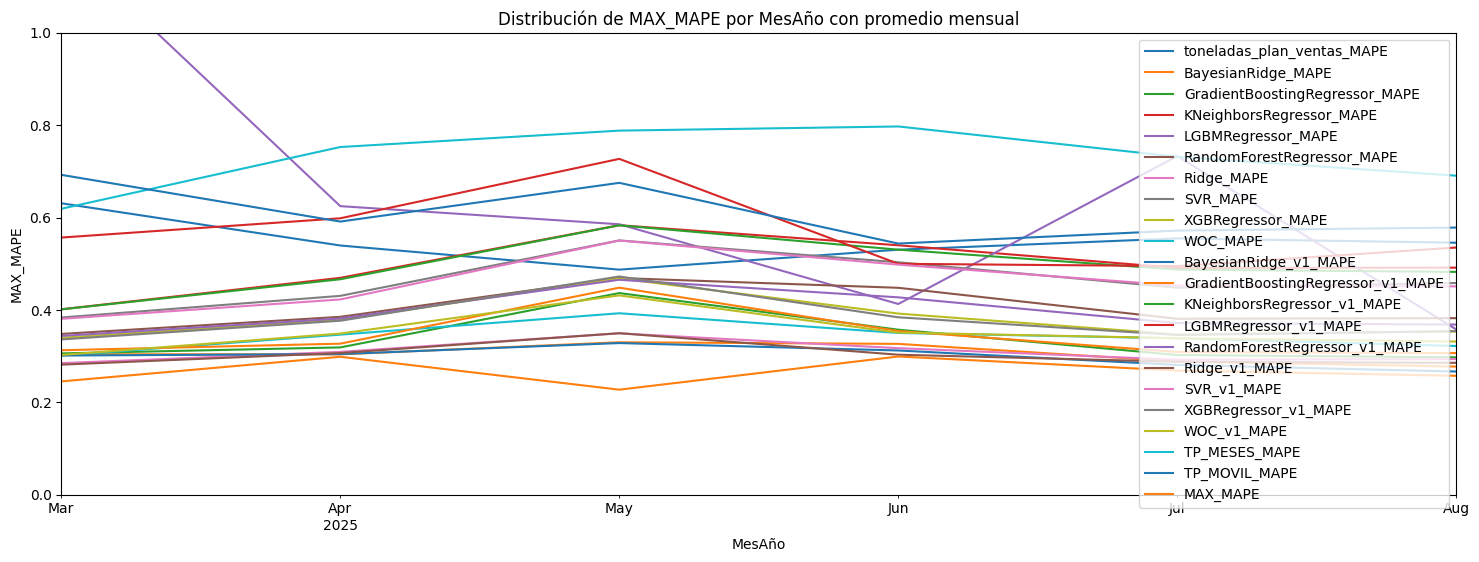

In [19]:

mapes = df.set_index("MesAnio")
mapes = mapes.loc[(mapes.MAX_MODEL == True), mapes.columns[mapes.columns.str.endswith("_MAPE")]].reset_index()
mapes = mapes.drop(columns = "Min_MAPE")

import matplotlib.pyplot as plt
# Crear el gráfico
plt.figure(figsize=(12, 6))
# Lineplot sobre el mismo eje
mapes[mapes.MesAnio < date_today].groupby("MesAnio").mean().plot(figsize=(18, 6))
# Limitar el eje Y de 0 a 1
plt.ylim(0, 1)

# Añadir leyenda y título
plt.legend()
plt.title("Distribución de MAX_MAPE por MesAño con promedio mensual")
plt.xlabel("MesAño")
plt.ylabel("MAX_MAPE")

plt.show()

In [20]:
# prueba de que existen MAPES repetidos......
df[avg_mape_cols].eq(df['Min_MAPE'], axis = 0).sum(axis = 1).value_counts().div(12)

21    906.0
1     541.0
20    245.0
2     149.0
19    124.0
18    105.0
17      3.0
5       3.0
9       2.0
11      2.0
4       2.0
3       2.0
8       2.0
16      1.0
6       1.0
15      1.0
14      1.0
Name: count, dtype: float64

In [21]:
df[df.MAX_MODEL == True].groupby("id2").MAX_Modelo.first().value_counts()

MAX_Modelo
BayesianRidge                   86
Ridge                           67
GradientBoostingRegressor       54
toneladas_plan_ventas           41
GradientBoostingRegressor_v1    31
XGBRegressor                    27
LGBMRegressor                   27
BayesianRidge_v1                26
Ridge_v1                        24
RandomForestRegressor           22
KNeighborsRegressor             19
WOC                             16
XGBRegressor_v1                 13
SVR                             13
LGBMRegressor_v1                11
TP_MESES                        10
KNeighborsRegressor_v1           8
WOC_v1                           8
RandomForestRegressor_v1         6
TP_MOVIL                         3
SVR_v1                           2
Name: count, dtype: int64

In [55]:
df.groupby("id2").MAX_Modelo.first().value_counts()

MAX_Modelo
toneladas_plan_ventas           1312
BayesianRidge                    249
TP_MOVIL                         106
Ridge                             74
GradientBoostingRegressor         69
TP_MESES                          64
XGBRegressor                      30
LGBMRegressor                     26
RandomForestRegressor             25
KNeighborsRegressor               23
BayesianRidge_v1                  21
Ridge_v1                          18
WOC                               17
SVR                               12
XGBRegressor_v1                   11
GradientBoostingRegressor_v1      11
KNeighborsRegressor_v1             7
RandomForestRegressor_v1           6
LGBMRegressor_v1                   5
SVR_v1                             3
WOC_v1                             3
Name: count, dtype: int64

In [ ]:
# GUARDAMOS RESULTADOS
from datetime import date
df.to_excel("outputs\Mejor_Pronostico{0}.xlsx".format(date.today(), index = False))

In [22]:
sns.lineplot(mean_mape, x="MesAnio", y="MAX_MAPE")

NameError: name 'sns' is not defined

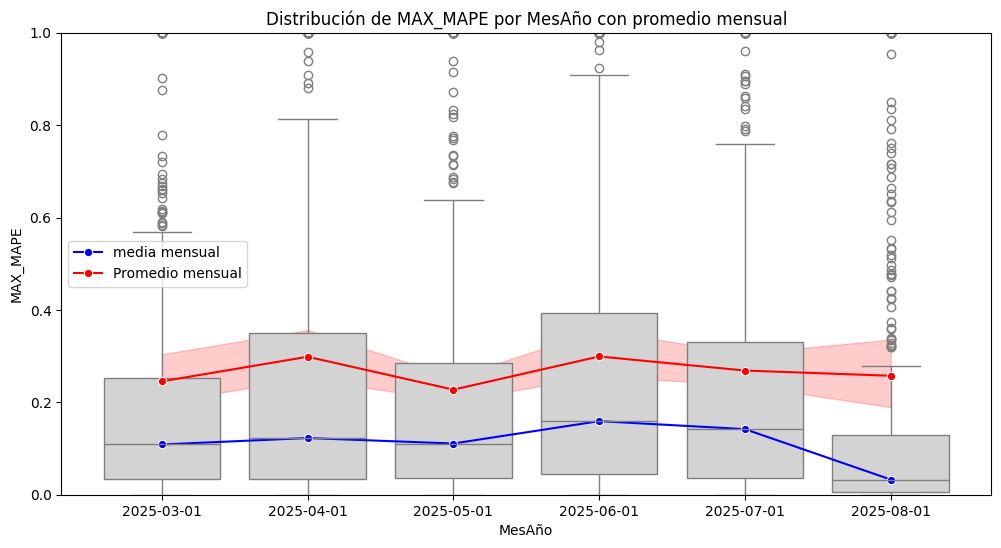

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar el DataFrame según la condición
filtered_df = df[(df.MAX_MODEL == True) & (df.MesAnio < date_today)]

# Calcular el promedio mensual sin convertir a datetime
mean_mape = filtered_df.groupby("MesAnio")['MAX_MAPE'].median().reset_index()
mean_mape['MesAnio'] = mean_mape['MesAnio'].astype(str)
filtered_df['MesAnio'] = filtered_df['MesAnio'].astype(str)

# Crear el gráfico
plt.figure(figsize=(12, 6))
# Lineplot sobre el mismo eje

# Boxplot
sns.boxplot(data=filtered_df, x="MesAnio", y="MAX_MAPE", color="lightgray")
sns.lineplot(data=mean_mape, x="MesAnio", y="MAX_MAPE", marker="o", label="media mensual", color="blue")

sns.lineplot(data=filtered_df, x="MesAnio", y="MAX_MAPE", marker="o", label="Promedio mensual", color="red")

# Limitar el eje Y de 0 a 1
plt.ylim(0, 1)

# Añadir leyenda y título
plt.legend()
plt.title("Distribución de MAX_MAPE por MesAño con promedio mensual")
plt.xlabel("MesAño")
plt.ylabel("MAX_MAPE")

plt.show()


In [24]:
condiciones = [df["MAX_Modelo"] == col  for col in cols2mape]
valores = [df[col]  for col in cols2mape]
# Valores a imputar según condiciones
df['FCST'] = np.select(condiciones, valores, default=None)
df["TO_PLOT"] = np.where(df.Segmento == 'Validacion',df["toneladas_facturadas"], df["FCST"])

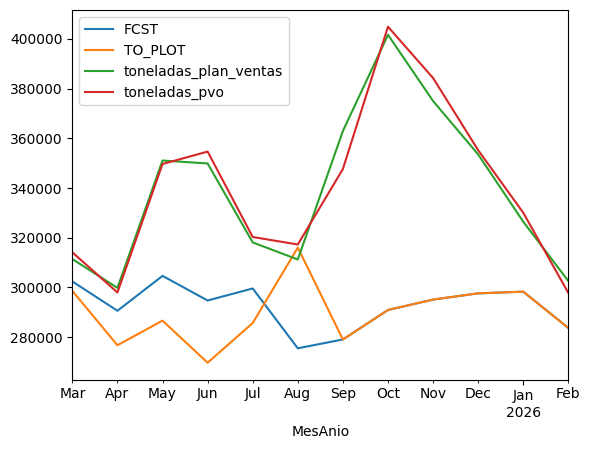

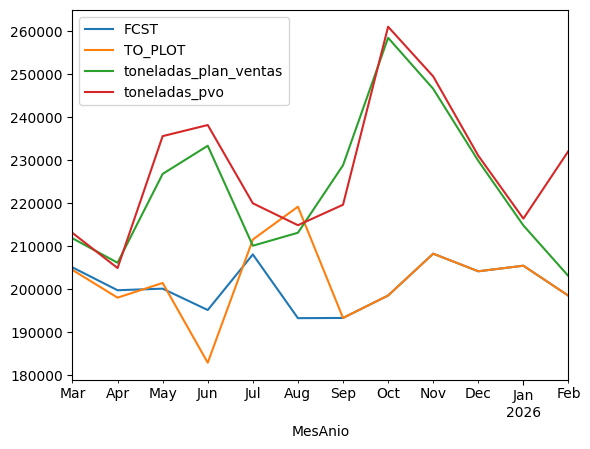

In [25]:
import matplotlib.pyplot as plt
df[  (df.MesAnio > "2025-02-03")].groupby("MesAnio").agg({"FCST":"sum", "TO_PLOT":"sum", "toneladas_plan_ventas":"sum", "toneladas_pvo":"sum"}).plot()
plt.show()
df[ (df.MAX_MODEL== True) & (df.MesAnio > "2025-02-03")].groupby("MesAnio").agg({"FCST":"sum", "TO_PLOT":"sum", "toneladas_plan_ventas":"sum", "toneladas_pvo":"sum"}).plot()
plt.show()

In [26]:
df[ (df.MesAnio > "2025-02-03")].groupby("MesAnio").agg({"FCST":"sum", "TO_PLOT":"sum", "toneladas_plan_ventas":"sum", "toneladas_pvo":"sum"})

,FCST,TO_PLOT,toneladas_plan_ventas,toneladas_pvo
MesAnio,,,,
2025-03-01,302394.968686,298605.668502,311391.500170,314116.19172
2025-04-01,290612.898363,276743.213118,299817.871770,297967.42046
2025-05-01,304637.290682,286633.726366,351031.823050,349645.48651
2025-06-01,294733.964045,269710.692785,349852.504730,354624.92090
2025-07-01,299576.103789,285686.192685,318095.420100,320277.35154
2025-08-01,275512.43821,316013.062493,311227.383510,317260.29013
2025-09-01,279064.647948,279064.647948,362910.375110,347611.79835
2025-10-01,290917.951203,290917.951203,401604.156994,404848.70302
2025-11-01,295108.966667,295108.966667,374963.959027,384219.57065


In [104]:
QUERY_PV = """
SELECT
FORMAT_DATE('%Y-%m-%d', PARSE_DATE('%B.%Y', mes_anio)) AS MesAnio,
nom_grupo AS NombreGrupo,
nom_direccion AS NombreDireccion,
#nom_subdireccion AS NombreSubdireccion,
#nom_grupo_estadistico1 AS NombreGrupoEstadistico1,
nom_grupo_estadistico2 AS NombreGrupoEstadistico2,
nom_grupo_estadistico3 AS NombreGrupoEstadistico3,
SUM(toneladas_plan_ventas) AS toneladas_plan_ventas,
SUM(toneladas_facturadas) AS toneladas_facturadas
FROM `datahub-deacero.mart_comercial.comercial` 
WHERE EXTRACT(YEAR FROM fecha) >= 2025 # Este es el que vamos a usar en productivo
AND 
nom_grupo IN ('ACEROS', 'ALAMBRES', 'FILIALES ALAMBRES', 'USA','DEACERO SOLUTIONS')
GROUP BY 1,2,3,4,5
"""

PV = data_bq(QUERY_PV)
PV.toneladas_plan_ventas = PV.toneladas_plan_ventas.astype(float)
PV.toneladas_facturadas = PV.toneladas_facturadas.astype(float)
PV.MesAnio = pd.to_datetime(PV.MesAnio)


In [105]:
ax = PV.groupby("MesAnio").agg({"toneladas_plan_ventas" : "sum" , "toneladas_facturadas": "sum"}).round(0)
#ax.set_ylim(210000, 280000)
#plt.show()
ax

,toneladas_plan_ventas,toneladas_facturadas
MesAnio,,
2025-01-01,230504.0,242982.0
2025-02-01,236418.0,217641.0
2025-03-01,246674.0,241413.0
2025-04-01,226953.0,216518.0
2025-05-01,267330.0,224794.0
2025-06-01,267159.0,213490.0
2025-07-01,240284.0,231663.0
2025-08-01,237440.0,247439.0
2025-09-01,258255.0,140955.0


In [113]:
QUERY_HISTORICO_FACTURACION = f"""
with data_base AS (

SELECT

FORMAT_DATE('%Y-%m-%d', PARSE_DATE('%B.%Y', mes_anio)) AS MesAnio,
nom_grupo AS NombreGrupo,
nom_direccion AS NombreDireccion,
nom_subdireccion AS NombreSubdireccion,
nom_grupo_estadistico1 AS NombreGrupoEstadistico1,
nom_grupo_estadistico2 AS NombreGrupoEstadistico2,
nom_grupo_estadistico3 AS NombreGrupoEstadistico3,
toneladas_facturadas AS toneladas_facturadas,
toneladas_plan_ventas AS toneladas_plan_ventas
FROM `datahub-deacero.mart_comercial.comercial` 
WHERE EXTRACT(YEAR FROM fecha) >= {2025} # Este es el que vamos a usar en productivo
AND nom_gerencia NOT IN ('ACERIAS SPOT')

)

# Agregar un cambio de valores para los cuales toneladas_facturadas es 0 si el valor original es negativo

SELECT 
MesAnio,NombreGrupo,NombreDireccion,
NombreSubdireccion,
NombreGrupoEstadistico1,
NombreGrupoEstadistico2,
NombreGrupoEstadistico3,
toneladas_plan_ventas,
CASE 
  #WHEN toneladas_facturadas IS NULL THEN -1
  #WHEN toneladas_facturadas < 0 THEN 0
  WHEN toneladas_facturadas >= 0 THEN toneladas_facturadas
  WHEN toneladas_facturadas < 0 THEN toneladas_facturadas
END toneladas_facturadas
FROM
(
SELECT 
data_base.MesAnio,
data_base.NombreGrupo,
data_base.NombreDireccion,
data_base.NombreSubdireccion,
data_base.NombreGrupoEstadistico1,
data_base.NombreGrupoEstadistico2,
data_base.NombreGrupoEstadistico3,
SUM(data_base.toneladas_facturadas) AS toneladas_facturadas,
SUM(data_base.toneladas_plan_ventas) AS toneladas_plan_ventas
FROM data_base
WHERE 
-- Descartamos los siguientes campos
NombreGrupo NOT IN ('EMPRESAS RELACIONADAS','TRASPASOS E INTEREMPRESAS')
AND
NombreDireccion NOT IN ('EXPORTACIÓN ALAMBRES')
AND
NombreSubdireccion NOT IN ('EXCEDENTES ACEROS','EXCEDENTES ALAMBRES','RESTO ALAMBRES','RESTO INGETEK')
AND
NombreGrupoEstadistico1 NOT IN ('CHATARRA','DEACERO POWER','INTERNAS PRODUCCION ','LOGÍSTICA','PALANQUILLA','SEGUNDAS')
AND
NombreGrupoEstadistico2 NOT IN ('SEGUNDAS / EXCEDENTES','CHQ')
AND
NombreGrupoEstadistico3 NOT IN ('DESPERDICIO','ALAMBRON SEGUNDAS','ALAMBRON EXCEDENTES','ALAMBRON TERCEROS','ALAMBRON OTROS','DERECHO DE VIA','PILOTES','PISO','POLIZAS')
-- Necesitamos que la informacion no sea nula
AND MesAnio IS NOT NULL
AND NombreGrupo IS NOT NULL
AND NombreDireccion IS NOT NULL
AND NombreSubdireccion IS NOT NULL
AND NombreGrupoEstadistico1 IS NOT NULL
AND NombreGrupoEstadistico2 IS NOT NULL
AND NombreGrupoEstadistico3 IS NOT NULL
GROUP BY
data_base.MesAnio,
data_base.NombreGrupo,
data_base.NombreDireccion,
data_base.NombreSubdireccion,
data_base.NombreGrupoEstadistico1,
data_base.NombreGrupoEstadistico2,
data_base.NombreGrupoEstadistico3
)
WHERE MesAnio < '2026-02-01'   
ORDER BY MesAnio ASC, toneladas_facturadas DESC
"""

PV = data_bq(QUERY_HISTORICO_FACTURACION)
PV.toneladas_plan_ventas = PV.toneladas_plan_ventas.astype(float)
PV.toneladas_facturadas = PV.toneladas_facturadas.astype(float)
PV.MesAnio = pd.to_datetime(PV.MesAnio)

In [114]:
ax2 = PV.groupby("MesAnio").agg({"toneladas_plan_ventas" : "sum" , "toneladas_facturadas": "sum"}).round(0)
#ax.set_ylim(210000, 280000)
#plt.show()
ax2

,toneladas_plan_ventas,toneladas_facturadas
MesAnio,,
2025-01-01,226840.0,238377.0
2025-02-01,232928.0,211521.0
2025-03-01,233207.0,225184.0
2025-04-01,223044.0,210760.0
2025-05-01,253691.0,217325.0
2025-06-01,254928.0,198934.0
2025-07-01,235226.0,221493.0
2025-08-01,228433.0,233837.0
2025-09-01,249804.0,133604.0


In [117]:
ax3 = FACT[FACT.NombreGrupo.isin(('ACEROS', 'ALAMBRES', 'FILIALES ALAMBRES', 'USA','DEACERO SOLUTIONS'))].groupby("MesAnio").agg({"toneladas_plan_ventas" : "sum" , "toneladas_facturadas": "sum"}).round(0)
ax3

,toneladas_plan_ventas,toneladas_facturadas
MesAnio,,
2025-01-01,230504.0,241909.0
2025-02-01,236418.0,215363.0
2025-03-01,246674.0,239033.0
2025-04-01,226953.0,215068.0
2025-05-01,267330.0,222701.0
2025-06-01,267159.0,211978.0
2025-07-01,240283.0,230111.0
2025-08-01,237440.0,245814.0
2025-09-01,258255.0,139154.0


In [118]:
to_test = ax.merge(ax2, how = "left", left_index = True,  right_index = True, suffixes=("_sin_filtros", "_confiltros"))
to_test = to_test.merge(ax3, how = "left", left_index = True,  right_index = True, suffixes=("", "_pronosticado"))
to_test["delta_pv"] = to_test["toneladas_plan_ventas_sin_filtros"] - to_test["toneladas_plan_ventas_confiltros"]
to_test.round(0)

,toneladas_plan_ventas_sin_filtros,toneladas_facturadas_sin_filtros,toneladas_plan_ventas_confiltros,toneladas_facturadas_confiltros,toneladas_plan_ventas,toneladas_facturadas,delta_pv
MesAnio,,,,,,,
2025-01-01,230504.0,242982.0,226840.0,238377.0,230504.0,241909.0,3664.0
2025-02-01,236418.0,217641.0,232928.0,211521.0,236418.0,215363.0,3490.0
2025-03-01,246674.0,241413.0,233207.0,225184.0,246674.0,239033.0,13467.0
2025-04-01,226953.0,216518.0,223044.0,210760.0,226953.0,215068.0,3909.0
2025-05-01,267330.0,224794.0,253691.0,217325.0,267330.0,222701.0,13639.0
2025-06-01,267159.0,213490.0,254928.0,198934.0,267159.0,211978.0,12231.0
2025-07-01,240284.0,231663.0,235226.0,221493.0,240283.0,230111.0,5058.0
2025-08-01,237440.0,247439.0,228433.0,233837.0,237440.0,245814.0,9007.0
2025-09-01,258255.0,140955.0,249804.0,133604.0,258255.0,139154.0,8451.0


In [70]:
ax = PV.groupby("MesAnio").agg({"toneladas_plan_ventas" : "sum" , "Toneladas_Facturadas": "sum"}).round(0)
#ax.set_ylim(210000, 280000)
#plt.show()
ax

,toneladas_plan_ventas,Toneladas_Facturadas
MesAnio,,
2025-01-01,226840.0,238520.788738000
2025-02-01,232928.0,211901.494838600
2025-03-01,233207.0,225601.163323300
2025-04-01,223044.0,211201.058465000
2025-05-01,253691.0,217533.690642100
2025-06-01,254928.0,198968.627792864
2025-07-01,235226.0,221497.078757624
2025-08-01,228433.0,233883.815011986
2025-09-01,249804.0,133605.737061966


In [58]:
FACT[FACT.NombreGrupo != "TRASPASOS E INTEREMPRESAS"].groupby(["NombreGrupo", "MesAnio"]).agg({"toneladas_plan_ventas" : "sum" , "toneladas_facturadas": "sum"}).round(0).unstack(0)

FACT[FACT.NombreGrupo != "TRASPASOS E INTEREMPRESAS"].groupby([ "MesAnio"]).agg({"toneladas_plan_ventas" : "sum" , "toneladas_facturadas": "sum"}).round(0)

,toneladas_plan_ventas,toneladas_facturadas
MesAnio,,
2025-01-01,230504.0,241909.0
2025-02-01,236418.0,215363.0
2025-03-01,246674.0,239033.0
2025-04-01,226953.0,215068.0
2025-05-01,267330.0,222701.0
2025-06-01,267159.0,211978.0
2025-07-01,240283.0,230111.0
2025-08-01,237440.0,245814.0
2025-09-01,258255.0,139154.0
